In [1]:
!pip install face_recognition
!pip install imutils

     |████████████████████████████████| 100.2MB 106kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566172 sha256=2142b51f9f4f46bad21f37f3ce11a472fd0d176e3e688464d607ad5eabd36f49
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models


In [2]:
from imutils import paths
import face_recognition
import cv2
import pickle
import os

### **Training the CNN using Image Embeddings**

Preparing training and test datasets:

In [3]:
!unzip '/content/105_classes_pins_dataset.zip'
!mkdir '/content/training/'
!mkdir '/content/testing/'
from IPython.display import clear_output
clear_output()

In [4]:
import os
import shutil

folder_path = '/content/105_classes_pins_dataset/'
people = os.listdir(folder_path)
for person in people:
  if person == ".DS_Store":
    pass
  else:
    name = str(person).split('_')[1]
    person_path = name+'/'
    # Create a training folder for this person
    train_dir = os.path.join('/content/training/',person_path)
    if not os.path.exists(train_dir):
        os.mkdir(train_dir)
    # Create a testing folder for this person
    test_dir = os.path.join('/content/testing/',person_path)
    if not os.path.exists(test_dir):
        os.mkdir(test_dir)

    # Move image files for each person into test and training sets
    images = os.listdir(os.path.join(folder_path,person))

    # Try training with 30 images to see results
    for train_img in images[:30]:
      source = os.path.join(folder_path,person,train_img)
      destination = os.path.join(train_dir)
      shutil.move(source, destination)
    # Test with 10 images per person
    for test_img in images[30:]:
      source = os.path.join(folder_path,person,test_img)
      destination = os.path.join(test_dir)
      shutil.move(source, destination)

In [5]:
# Create empty lists for known encodings and known names
knownEncodings = []
knownNames = []

# Create list for image paths to our training data
imagePaths = []
for person in os.listdir('/content/training/'):
  for image in os.listdir(os.path.join('/content/training/',person)):
    imagePaths.append(os.path.join('/content/training/',person,image))

# Expecting 3150(105*30) paths
print(len(imagePaths))

3150


In [6]:
# Loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
	# Extract the person name from the image path
  clear_output()
  print("[INFO] processing image {}/{}".format(i + 1,
		len(imagePaths)))
  name = imagePath.split(os.path.sep)[-2]
  
  # Load the input image and convert it from BGR (OpenCV ordering) to dlib ordering (RGB)
  image = cv2.imread(imagePath)
  rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
 
  # Detect the (x, y)-coordinates of the bounding boxes corresponding to each face in the input image
  boxes = face_recognition.face_locations(rgb, model="cnn")
 
	# Compute facial embedding for each face
  encodings = face_recognition.face_encodings(rgb, boxes)
 
	# Loop over the encodings and append to knownEncodings and knownNames lists
  for encoding in encodings:
    knownEncodings.append(encoding)
    knownNames.append(name)

[INFO] processing image 3150/3150


In [7]:
# Dump the facial encodings and names to disk
data = {"encodings": knownEncodings, "names": knownNames}
f = open('celebEncodings.pickle', "wb")
f.write(pickle.dumps(data))
f.close()

### **Testing Face Recognition in Test Images**

In [18]:
# Load the input image and convert it from BGR to RGB
test_img_path = '/content/testing/margot robbie/margot robbie10_3058.jpg'
image = cv2.imread(test_img_path)
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Detect the (x, y)-coordinates of the bounding boxes corresponding to each face in the input image, then compute the facial embeddings
boxes = face_recognition.face_locations(rgb,
	model="cnn")
encodings = face_recognition.face_encodings(rgb, boxes)

# Empty list to store names for each face detected
names = []

In [19]:
# Loop over the facial embeddings
for encoding in encodings:
	# Attempt to match each face in the input image to our known encodings
	matches = face_recognition.compare_faces(data["encodings"],encoding)
	name = "Unknown"

# Check to see if we have found a match
if True in matches:
	# Find the indexes of all matched faces then initialize a dictionary to count the total number of times each face was matched
	matchedIdxs = [i for (i, b) in enumerate(matches) if b]
	counts = {}
	# Loop over the matched indexes and maintain a count for each recognized face
	for i in matchedIdxs:
		name = data["names"][i]
		counts[name] = counts.get(name, 0) + 1
	# Determine the recognized face with the largest number of votes (note: in the event of an unlikely tie Python will select first entry in the dictionary)
	name = max(counts, key=counts.get)
	
# Update the list of names
names.append(name)

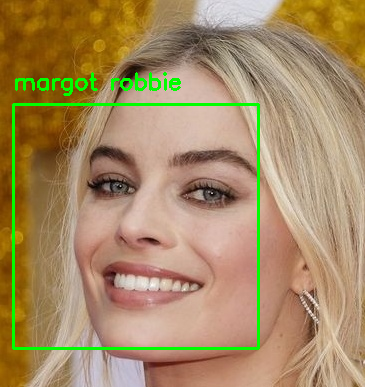

-1

In [20]:
from google.colab.patches import cv2_imshow
# Loop over the recognized faces
for ((top, right, bottom, left), name) in zip(boxes, names):
	# draw the predicted face name on the image
	cv2.rectangle(image, (left, top), (right, bottom), (0, 255, 0), 2)
	y = top - 15 if top - 15 > 15 else top + 15
	cv2.putText(image, name, (left, y), cv2.FONT_HERSHEY_SIMPLEX,
		0.75, (0, 255, 0), 2)
 
# Show the output image
cv2_imshow(image)
cv2.waitKey(0)

### **Calculating Accuracy of Face Recognition in Test Images**

In [22]:
""" 
Function to check if Face Recognition is correct, returns True if yes and False if not
"""

def recognise_face(test_img_path):
  image = cv2.imread(test_img_path)
  rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # Detect the (x, y)-coordinates of the bounding boxes corresponding to each face in the input image, then compute the facial embeddings
  boxes = face_recognition.face_locations(rgb,model="cnn")
  encodings = face_recognition.face_encodings(rgb, boxes)

  # Empty string for detected name since only one person in test images
  person_name = ''

  # Loop over the facial embeddings
  for encoding in encodings:
    # Attempt to match each face in the input image to our known encodings
    matches = face_recognition.compare_faces(data["encodings"],encoding)
    name = "Unknown"
  
  # Check to see if we have found a match
  if True in matches:
    # Find the indexes of all matched faces then initialize a dictionary to count the total number of times each face was matched
    matchedIdxs = [i for (i, b) in enumerate(matches) if b]
    counts = {}
    # Loop over the matched indexes and maintain a count for each recognized face
    for i in matchedIdxs:
      name = data["names"][i]
      counts[name] = counts.get(name, 0) + 1
    # Determine the recognized face with the largest number of votes (note: in the event of an unlikely tie Python will select first entry in the dictionary)
    name = max(counts, key=counts.get)
	
  # Update the list of names
  person_name = name

  # Get person's name from test_img_path
  name_from_path = test_img_path.split(os.path.sep)[-2]
  
  return name == name_from_path

In [23]:
test_path = '/content/testing/Zendaya/Zendaya105_1793.jpg'
recognise_face(test_path)

# Expecting True for correct match

True

In [30]:
# Create dictionary to keep track of how many correct images were guessed for each person
correct_matches = {}

my_test_dir = '/content/testing'
for person in os.listdir(my_test_dir):
  person_path = os.path.join(my_test_dir, person)
  for test_img in os.listdir(person_path):
    if test_img == "Store":
      pass # To avoid error from a non-image file
    else:
      test_img_path = os.path.join(person_path,test_img)
      if recognise_face(test_img_path):
        if person in correct_matches:
          correct_matches[person] += 1
        else:
          correct_matches[person] =1

In [31]:
correct_matches

{'Adriana Lima': 10,
 'Alex Lawther': 10,
 'Alexandra Daddario': 10,
 'Alvaro Morte': 10,
 'Amanda Crew': 10,
 'Andy Samberg': 10,
 'Anne Hathaway': 9,
 'Anthony Mackie': 10,
 'Avril Lavigne': 9,
 'Ben Affleck': 9,
 'Bill Gates': 9,
 'Bobby Morley': 10,
 'Brenton Thwaites': 10,
 'Brian J. Smith': 10,
 'Brie Larson': 10,
 'Chris Evans': 9,
 'Chris Hemsworth': 10,
 'Chris Pratt': 10,
 'Christian Bale': 10,
 'Cristiano Ronaldo': 10,
 'Danielle Panabaker': 10,
 'Dominic Purcell': 10,
 'Dwayne Johnson': 10,
 'Eliza Taylor': 9,
 'Elizabeth Lail': 10,
 'Emilia Clarke': 9,
 'Emma Stone': 10,
 'Emma Watson': 10,
 'Gwyneth Paltrow': 10,
 'Henry Cavil': 9,
 'Hugh Jackman': 10,
 'Inbar Lavi': 10,
 'Irina Shayk': 10,
 'Jake Mcdorman': 9,
 'Jason Momoa': 10,
 'Jennifer Lawrence': 8,
 'Jeremy Renner': 10,
 'Jessica Barden': 10,
 'Jimmy Fallon': 10,
 'Johnny Depp': 10,
 'Josh Radnor': 10,
 'Katharine Mcphee': 10,
 'Katherine Langford': 10,
 'Keanu Reeves': 10,
 'Krysten Ritter': 9,
 'Leonardo DiCaprio

In [32]:
# Calculate overall accuracy by summing key values
# Note total test images are 1040 (104*10) as Millie Bobby Brown test images were corrupted

total_correct = sum(correct_matches.values())
accuracy = (total_correct/1040)*100
print(f"Overall accuracy on test images is: {accuracy:.2f}%")

Overall accuracy on test images is: 97.60%
